In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/cataract"


cataract  normal


In [ ]:
import os, glob, shutil
from sklearn.model_selection import train_test_split

source_dir = "/content/drive/MyDrive/cataract"
base_dir = "/content/data"

# Define target dirs
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Remove old directory if exists
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Make new ones
for dir_path in [train_dir, val_dir, test_dir]:
    for cls in ["normal", "cataract"]:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)

# Split & copy
for cls in ["normal", "cataract"]:
    all_imgs = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        all_imgs.extend(glob.glob(os.path.join(source_dir, cls, ext)))

    print(f"{cls}: {len(all_imgs)} images found")

    train_imgs, temp_imgs = train_test_split(all_imgs, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(img, os.path.join(train_dir, cls))
    for img in val_imgs:
        shutil.copy(img, os.path.join(val_dir, cls))
    for img in test_imgs:
        shutil.copy(img, os.path.join(test_dir, cls))

print("Split complete")


normal: 11917 images found
cataract: 8908 images found
Split complete


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)
# Fix class mapping
class_indices = train_gen.class_indices
print("Class indices:", class_indices)

# Reverse mapping: {0: 'cataract', 1: 'normal'}
class_names = {v: k for k, v in class_indices.items()}



Found 14576 images belonging to 2 classes.
Found 3124 images belonging to 2 classes.
Found 3125 images belonging to 2 classes.
Class indices: {'cataract': 0, 'normal': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze most layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 1,534,273 (5.85 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 296s 595ms/step - accuracy: 0.9575 - loss: 0.1058 - val_accuracy: 0.9523 - val_loss: 0.1694 - learning_rate: 1.0000e-04
Epoch 2/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 239s 525ms/step - accuracy: 0.9900 - loss: 0.0269 - val_accuracy: 0.9869 - val_loss: 0.0389 - learning_rate: 1.0000e-04
Epoch 3/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 235s 515ms/step - accuracy: 0.9912 - loss: 0.0221 - val_accuracy: 0.9866 - val_loss: 0.0378 - learning_rate: 1.0000e-04
Epoch 4/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 231s 507ms/step - accuracy: 0.9926 - loss: 0.0190 - val_accuracy: 0.9853 - val_loss: 0.0504 - learning_rate: 1.0000e-04
Epoch 5/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 233s 510ms/step - accuracy: 0.9944 - loss: 0.0157 - val_accuracy: 0.9891 - val_loss: 0.0367 - learning_rate: 1.0000e-04
Epoch 6/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 237s 519ms/step - accuracy: 0.9940 - loss: 0.0155 - val_accuracy: 0.9878 - val_loss: 0.0353 - learning_rate: 1.0000e-04
Epoch 7/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9922 - loss: 0.0252

 Test Accuracy: 99.33%


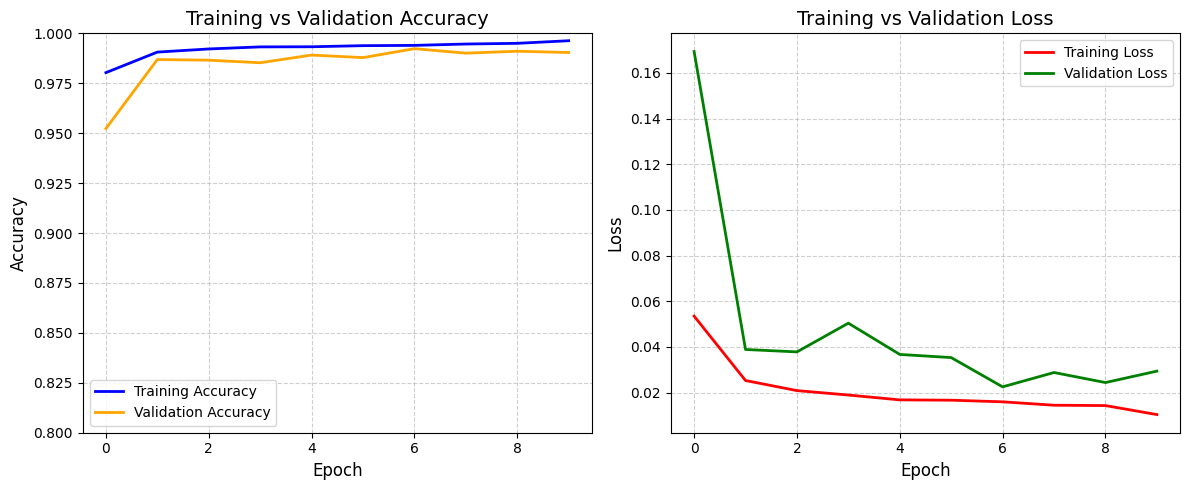

In [ ]:
import matplotlib.pyplot as plt

#Improved plots for accuracy & loss

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(0.8, 1.0)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step


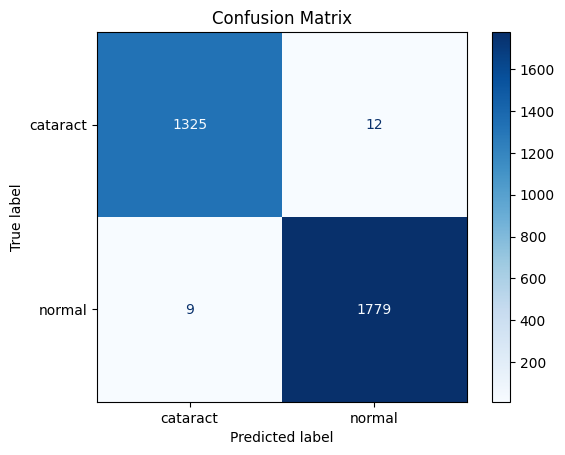


Classification Report:
              precision    recall  f1-score   support

    cataract       0.99      0.99      0.99      1337
      normal       0.99      0.99      0.99      1788

    accuracy                           0.99      3125
   macro avg       0.99      0.99      0.99      3125
weighted avg       0.99      0.99      0.99      3125



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

#Get true and predicted labels
Y_true = test_gen.classes
Y_pred = model.predict(test_gen)
Y_pred_classes = (Y_pred > 0.5).astype(int).flatten()

#Class labels (order is same as in test_gen.class_indices)
class_labels = list(test_gen.class_indices.keys())

#Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#Classification Report
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))


Selected image: /content/data/test/cataract/13_jpg.rf.edd117f3e0dbb2b9b93f07ac22b31b47.jpg
Using last conv layer: Conv_1


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


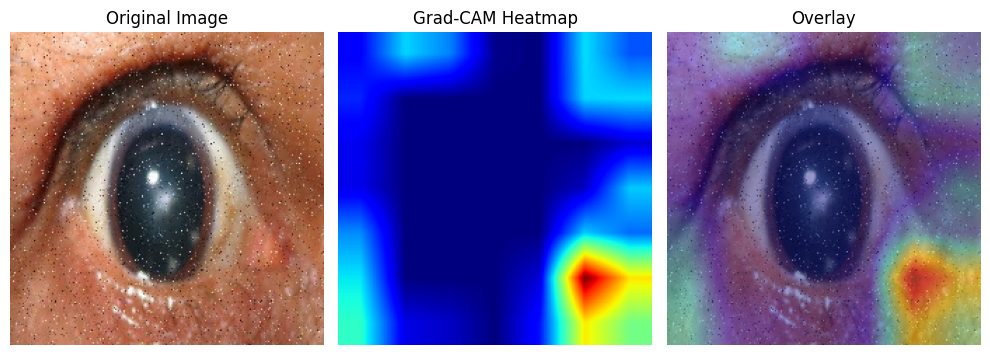

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import os

#Pick a random image from test set
test_class = random.choice(["normal", "cataract"])
test_folder = os.path.join(test_dir, test_class)
test_image_path = random.choice(os.listdir(test_folder))
test_image_path = os.path.join(test_folder, test_image_path)

print(f"Selected image: {test_image_path}")

#Load and preprocess image
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

#Get the last convolutional layer
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

if last_conv_layer is None:
    for layer in reversed(model.layers):
        if hasattr(layer, "output_shape") and len(layer.output_shape) == 4:
            last_conv_layer = layer.name
            break

print(f"Using last conv layer: {last_conv_layer}")

#Create grad model
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer).output, model.output]
)

#Compute gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    predicted_class = tf.argmax(predictions[0])
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

#Compute Grad-CAM heatmap
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
heatmap = cv2.resize(heatmap, (224, 224))

#Overlay heatmap on image
original_img = cv2.imread(test_image_path)
original_img = cv2.resize(original_img, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

#Show results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

Using last conv layer: Conv_1


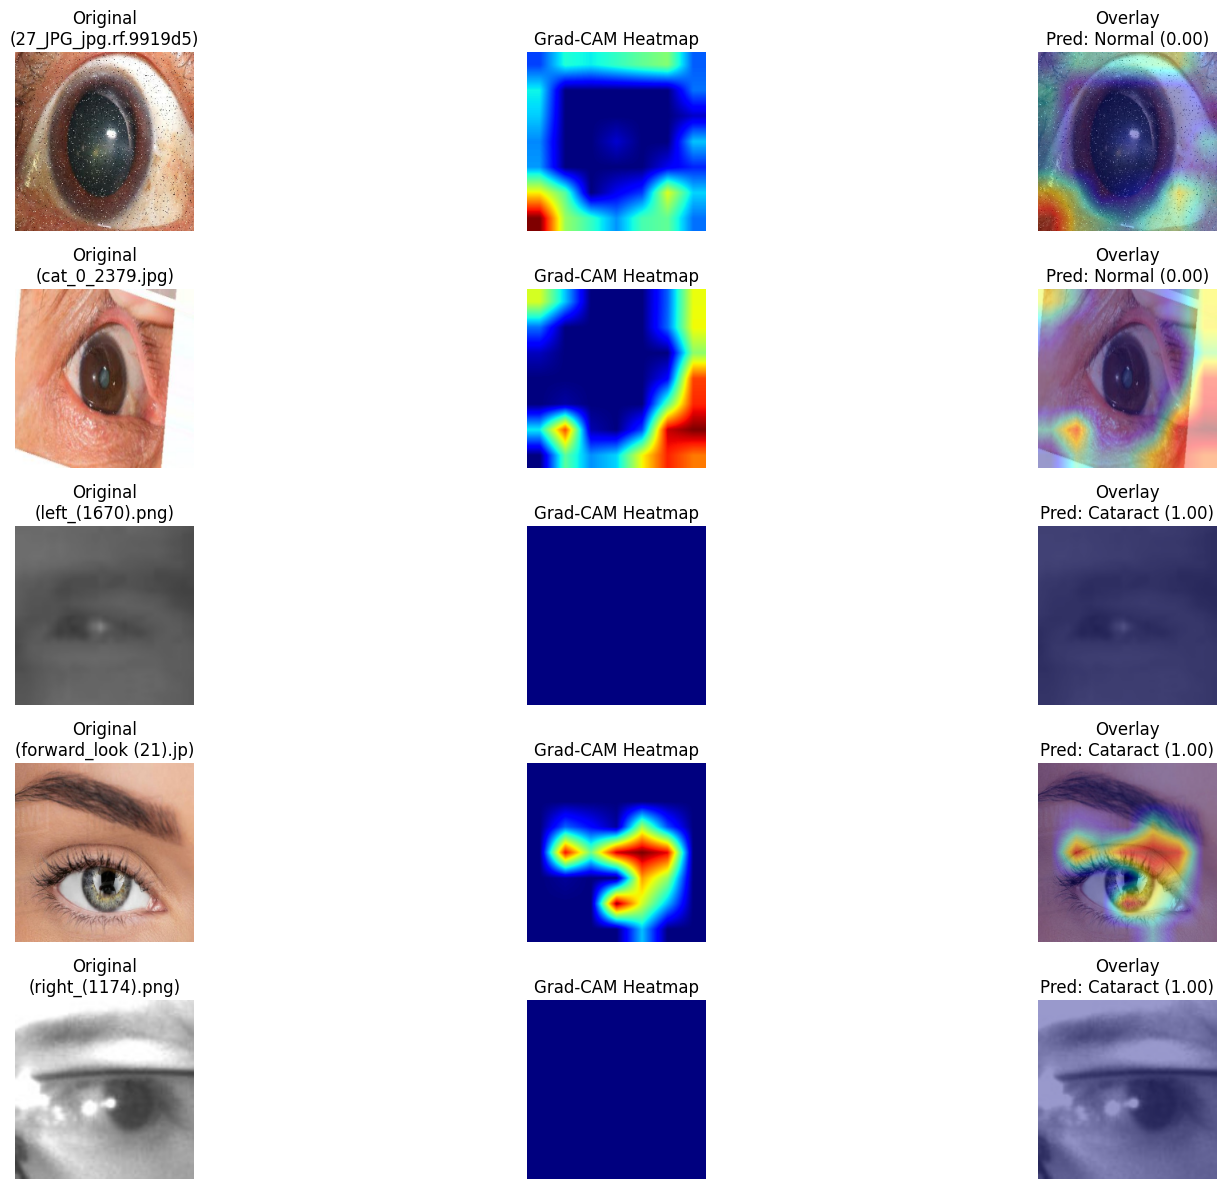

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import os

#Get the last convolutional
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

if last_conv_layer is None:
    for layer in reversed(model.layers):
        if hasattr(layer, "output_shape") and len(layer.output_shape) == 4:
            last_conv_layer = layer.name
            break

print(f"Using last conv layer: {last_conv_layer}")

#Create grad model
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer).output, model.output]
)

#Function to generate Grad-CAM for one image
def get_gradcam(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # Fix: Handle case where max_heatmap is zero to avoid division by zero
    max_heatmap = np.max(heatmap)
    if max_heatmap == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap = heatmap / max_heatmap

    heatmap = cv2.resize(heatmap, (224, 224))

    # Overlay
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

    predicted_label = "Cataract" if predictions[0][0] > 0.5 else "Normal"
    prob = predictions[0][0]
    return original_img, heatmap, overlay, predicted_label, prob

#Select 5 random images from test_dir
image_paths = []
for _ in range(5):
    cls = random.choice(["normal", "cataract"])
    folder = os.path.join(test_dir, cls)
    img_path = random.choice(os.listdir(folder))
    image_paths.append(os.path.join(folder, img_path))

#Plot all Grad-CAMs
plt.figure(figsize=(18, 12))
for i, img_path in enumerate(image_paths):
    orig, heat, overlay, label, prob = get_gradcam(img_path)

    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Original\n({os.path.basename(img_path)[:20]})")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(heat, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\nPred: {label} ({prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()

Class mapping: {0: 'cataract', 1: 'normal'}


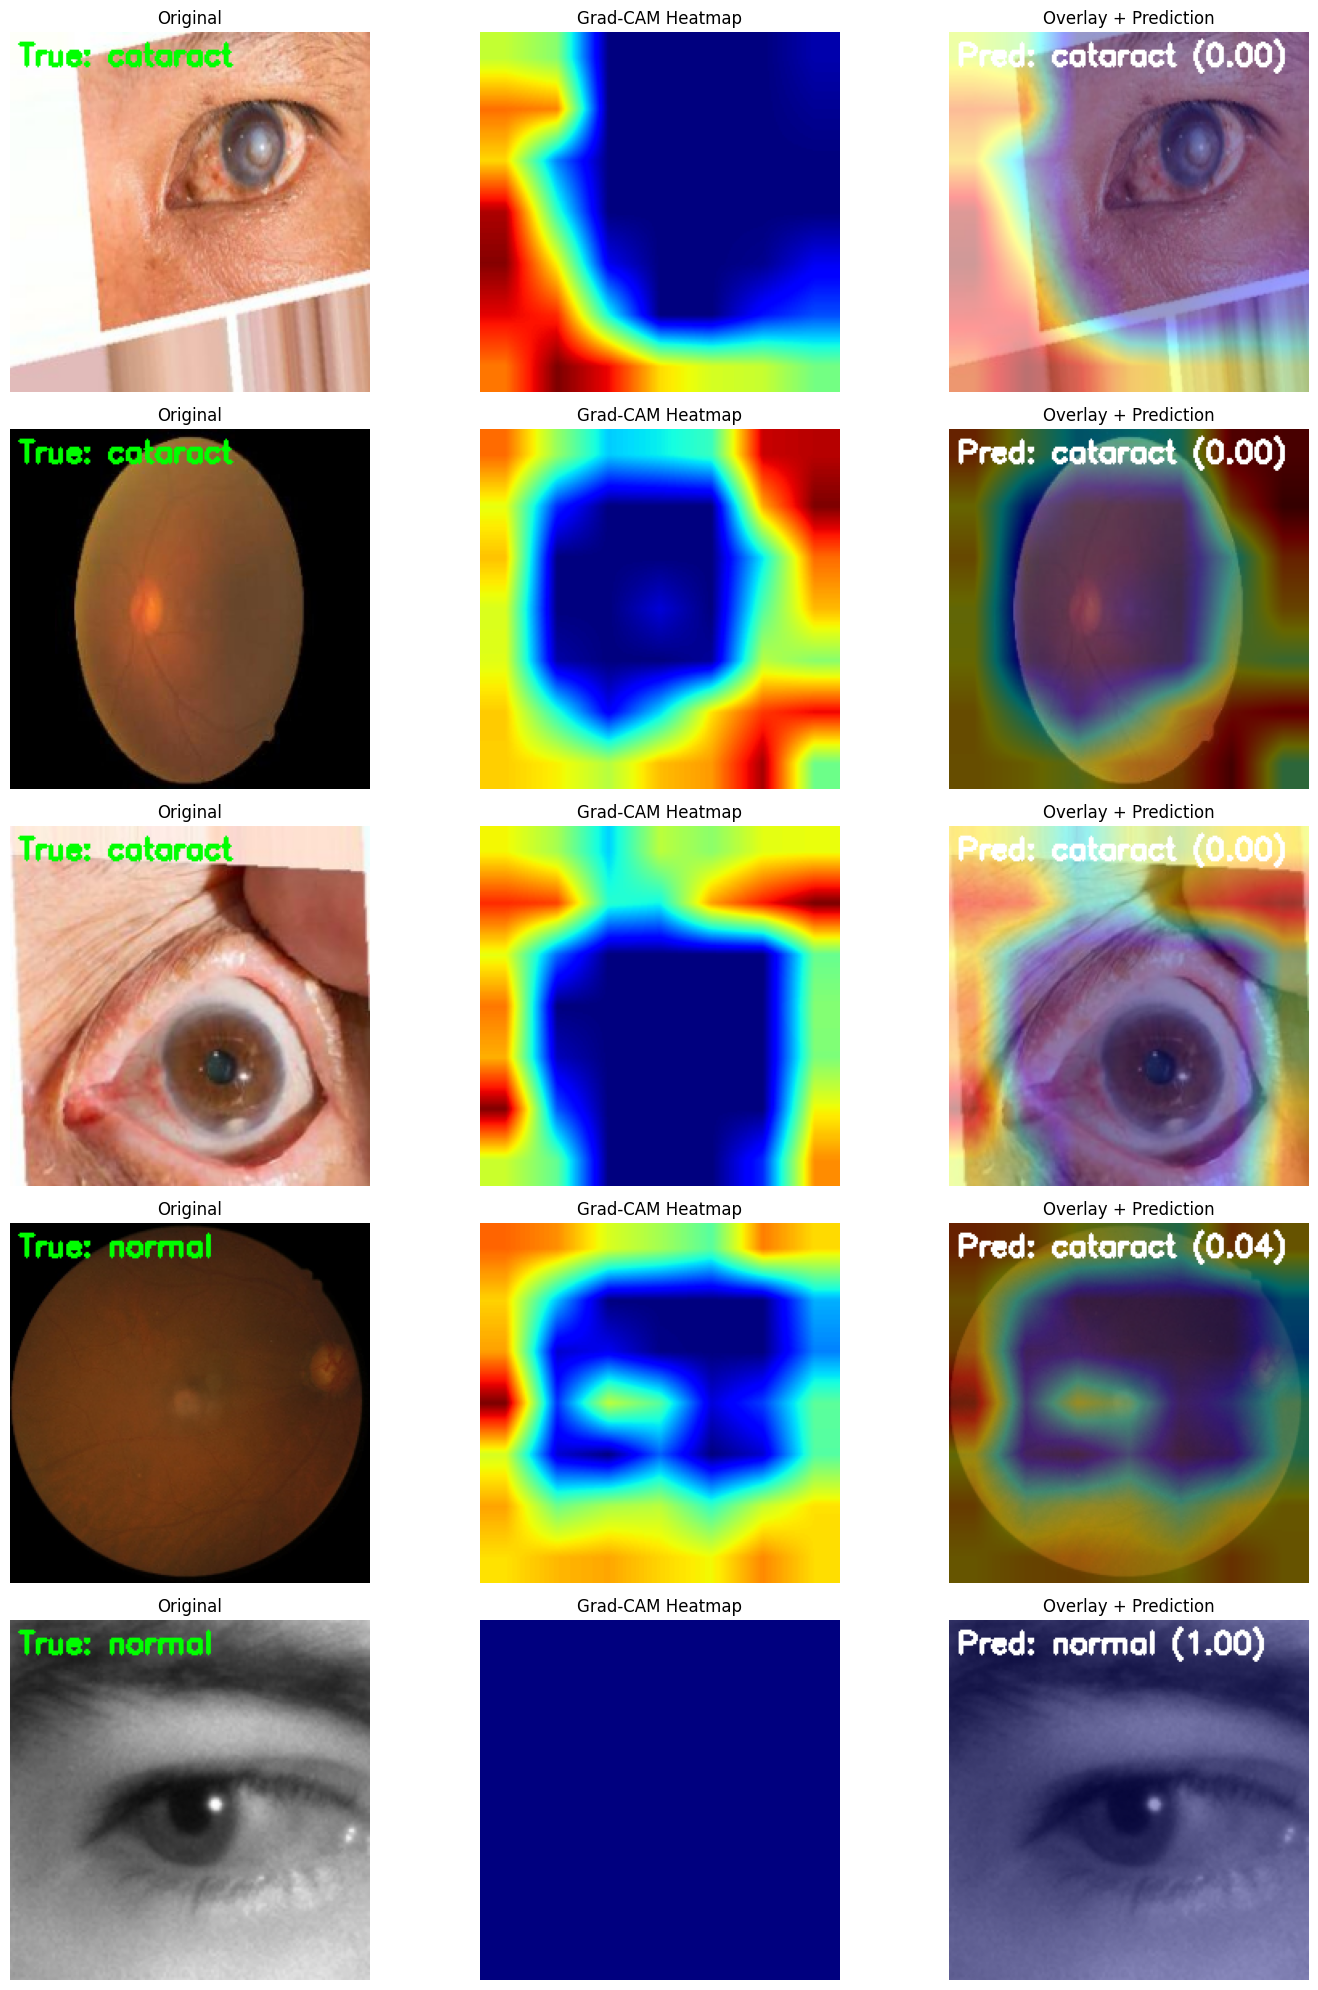

In [ ]:
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

#Class mapping fix
class_indices = train_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}  # 0 -> class name, 1 -> class name
print("Class mapping:", class_names)

#Pick 5 random images from test set
test_images = []
for cls in ["normal", "cataract"]:
    cls_folder = os.path.join(test_dir, cls)
    cls_images = [os.path.join(cls_folder, img) for img in os.listdir(cls_folder)]
    test_images.extend(cls_images)

random_images = random.sample(test_images, 5)

#Detect last conv layer
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break
if last_conv_layer is None:
    raise ValueError("No Conv2D layer found in the model!")

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer).output, model.output]
)

#Function to process each image
def process_image(img_path):
    # Load and preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Grad-CAM
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # Handle case where max_heatmap is zero to avoid division by zero
    max_heatmap = np.max(heatmap)
    if max_heatmap == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap = heatmap / max_heatmap

    # Fix: Remove .numpy() as heatmap is already a numpy array
    heatmap = cv2.resize(heatmap, (224, 224))

    # Overlay
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

    # Prediction
    pred_class = int(np.round(predictions[0][0]))
    pred_label = class_names[pred_class]
    pred_prob = predictions[0][0]

    # True label from folder
    true_label = os.path.basename(os.path.dirname(img_path))

    return original_img, heatmap, superimposed_img, pred_label, pred_prob, true_label

#Process and display all 5 images
plt.figure(figsize=(15, 20))

for i, img_path in enumerate(random_images):
    original_img, heatmap, superimposed_img, pred_label, pred_prob, true_label = process_image(img_path)

    # Original image with true label
    img_with_text = original_img.copy()
    cv2.putText(img_with_text, f"True: {true_label}", (5, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # Overlay image with prediction
    overlay_with_text = superimposed_img.copy()
    cv2.putText(overlay_with_text, f"Pred: {pred_label} ({pred_prob:.2f})", (5, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    # Original
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(cv2.cvtColor(img_with_text, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    # Heatmap
    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    # Overlay with prediction
    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(cv2.cvtColor(overlay_with_text, cv2.COLOR_BGR2RGB))
    plt.title("Overlay + Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

Class indices: {'cataract': 0, 'normal': 1}


Saving eye image 2.jpg to eye image 2.jpg
Using last conv layer: Conv_1
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Raw prediction probability: 0.612
Prediction: normal


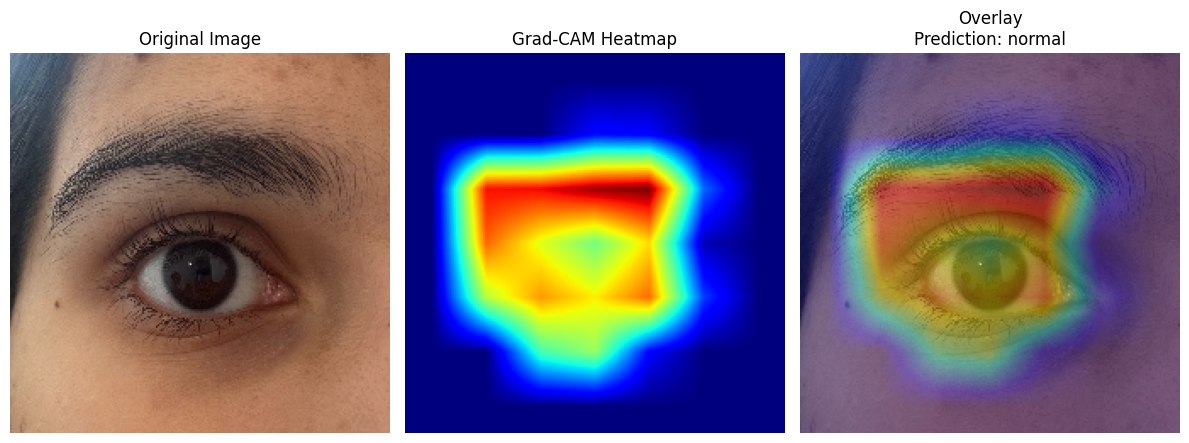

In [ ]:
#Fix class mapping based on train_gen
class_indices = train_gen.class_indices
print("Class indices:", class_indices)
class_names = {v: k for k, v in class_indices.items()}  # 0->class name, 1->class name

#Upload your own eye image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

#Load and preprocess image
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

#Detect last convolutional layer automatically
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

if last_conv_layer is None:
    raise ValueError("No Conv2D layer found in the model!")

print(f"Using last conv layer: {last_conv_layer}")

#Create grad model
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer).output, model.output]
)

#Compute Grad-CAM
import tensorflow as tf

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, 0]  # binary classification

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)

# Handle case where max_heatmap is zero to avoid division by zero
max_heatmap = np.max(heatmap)
if max_heatmap == 0:
    heatmap = np.zeros_like(heatmap)
else:
    heatmap = heatmap / max_heatmap

# Fix: Remove .numpy() as heatmap is already a numpy array
heatmap = cv2.resize(heatmap, (224, 224))

#Overlay heatmap on original image
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

#Make prediction
preds = model.predict(img_array)
pred_class = int(np.round(preds[0][0]))
print(f"Raw prediction probability: {preds[0][0]:.3f}")
print(f"Prediction: {class_names[pred_class]}")

#Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Overlay\nPrediction: {class_names[pred_class]}")
plt.axis("off")

plt.tight_layout()
plt.show()